### Option C: Use collaborative filtering to build a custom recommendation system
### Team : Balasubramaniam Dakshinamoorthi


### Business Understanding:

Dataset used here is Amazon Reviews data http://jmcauley.ucsd.edu/data/amazon/ for Electronics products only. This data is used by Amazon to make recommendation for online electronics purchases. Data was collected by Amazon shopper who shop on their website and anonymized to protect the identity. 

In this evaluation we will evaluate two methods one using popularity based (non-personalized) model second using Collaborative Filtering model. We will use RMSE (room mean squred error) to evaluate the effectiveness of our models.

The root mean squared error (RMSE) takes into account the difference between the predicted rating and the actual rating of items. However, we can calculate it in a number of different aggregated ways (i.e., splits and aggregation). For instance, we could just take the average RMSE of every entry in the dataset. Or, we could take the average RMSE for each user, or the average RMSE for each item. It really depends on what we are most interested in (i.e., out business case).


### Data Understanding:

Dataset used here was Amazon Reviews data http://jmcauley.ucsd.edu/data/amazon/ for Electronics products only. Dataset includes user id, Product id, Rating. There are close to 8 million reviews with 3 column. Data did not contained any missing values. With target Rating raning from 1 - 5.

Given the data sparsity and size of data, we choose to make data dense by removing users who had less than 50 reviews. This parameter could be adjusted to evaluate actual prediction score it's impact. 

After making data dense we have total of 125,871 users who have rated 50 or more items. Our unique users in final data is 1540 with unique number of 48,190 items.


## Import Required Libraries

In [42]:
import numpy as np
import pandas as pd
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.externals import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

### Read and explore the dataset

In [45]:
#Import the data set
df = pd.read_csv('ratings_Electronics.csv', header=None)
df.columns = ['user_id', 'prod_id', 'rating', 'prod_name']
df = df.drop('prod_name', axis=1)

In [46]:
# see few rows of the imported dataset
df.tail()

,user_id,prod_id,rating
7824477,A2YZI3C9MOHC0L,BT008UKTMW,5.0
7824478,A322MDK0M89RHN,BT008UKTMW,5.0
7824479,A1MH90R0ADMIK0,BT008UKTMW,4.0
7824480,A10M2KEFPEQDHN,BT008UKTMW,4.0
7824481,A2G81TMIOIDEQQ,BT008V9J9U,5.0


In [47]:
# Check the number of rows and columns
rows, columns = df.shape
print("No of rows: ", rows) 
print("No of columns: ", columns) 

No of rows:  7824482
No of columns:  3


In [48]:
#Check Data types
df.dtypes

user_id     object
prod_id     object
rating     float64
dtype: object

In [49]:
# Check for missing values present
print('Number of missing values across columns-\n', df.isnull().sum())

Number of missing values across columns-
 user_id    0
prod_id    0
rating     0
dtype: int64


### There are no missing values with total records 7824482

In [7]:
# Summary statistics of 'rating' variable
df[['rating']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
rating,7824482.0,4.012337,1.38091,1.0,3.0,5.0,5.0,5.0


In [50]:
# find minimum and maximum ratings 
print('The minimum rating is: %d' %(df['rating'].min()))
print('The maximum rating is: %d' %(df['rating'].max()))    

The minimum rating is: 1
The maximum rating is: 5


### Ratings are on scale of 1 - 5

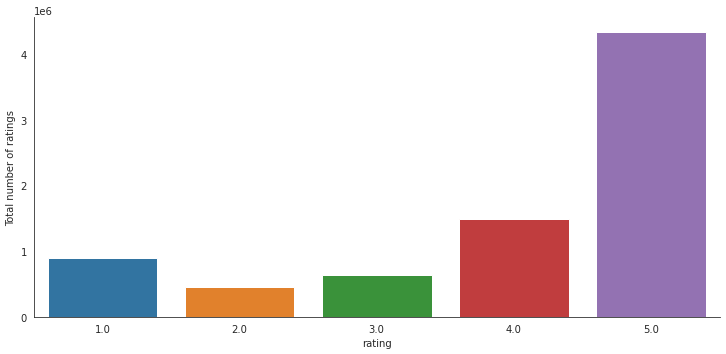

In [51]:
# Check the distribution of ratings 
with sns.axes_style('white'):
    g = sns.factorplot("rating", data=df, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings") 

In [52]:
# Number of unique user id and product id in the data
print('Number of unique USERS in Raw data = ', df['user_id'].nunique())
print('Number of unique ITEMS in Raw data = ', df['prod_id'].nunique())

Number of unique USERS in Raw data =  4201696
Number of unique ITEMS in Raw data =  476002


### Our dataset is sparse, we will only keep the users who has given 50 or more rating to make it more dense.

In [54]:
counts = df['user_id'].value_counts()
df_final = df[df['user_id'].isin(counts[counts >= 50].index)]

In [55]:
print('Number of users who have rated 50 or more items =', len(df_final))
print('Number of unique USERS in final data = ', df_final['user_id'].nunique())
print('Number of unique ITEMS in final data = ', df_final['prod_id'].nunique())

Number of users who have rated 50 or more items = 125871
Number of unique USERS in final data =  1540
Number of unique ITEMS in final data =  48190


#### Calculate the density of the rating matrix

In [56]:
final_ratings_matrix = df_final.pivot(index = 'user_id', columns ='prod_id', values = 'rating').fillna(0)
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)

possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)

density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

Shape of final_ratings_matrix:  (1540, 48190)
given_num_of_ratings =  125871
possible_num_of_ratings =  74212600
density: 0.17%


In [57]:
final_ratings_matrix.tail()

prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_id,,,,,,,,,,,,,,,,,,,,,
AZBXKUH4AIW3X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZCE11PSTCH1L,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZMY6E8B52L2T,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZNUHQSHZHSUE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZOK5STV85FBJ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
# Matrix with one row per 'Product' and one column per 'user' for Item-based CF
final_ratings_matrix_T = final_ratings_matrix.transpose()
final_ratings_matrix_T.head()

user_id,A100UD67AHFODS,A100WO06OQR8BQ,A105S56ODHGJEK,A105TOJ6LTVMBG,A10AFVU66A79Y1,A10H24TDLK2VDP,A10NMELR4KX0J6,A10O7THJ2O20AG,A10PEXB6XAQ5XF,A10X9ME6R66JDX,...,AYOTEJ617O60K,AYP0YPLSP9ISM,AZ515FFZ7I2P7,AZ8XSDMIX04VJ,AZAC8O310IK4E,AZBXKUH4AIW3X,AZCE11PSTCH1L,AZMY6E8B52L2T,AZNUHQSHZHSUE,AZOK5STV85FBJ
prod_id,,,,,,,,,,,,,,,,,,,,,
0594451647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0594481813,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0970407998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0972683275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1400501466,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Split the data randomly into train and test dataset, split ratio 70/30

In [59]:
#Split the training and test data in the ratio 70:30
train_data, test_data = train_test_split(df_final, test_size = 0.3, random_state=0)

print(train_data.head(5))

                user_id     prod_id  rating
6595853  A2BYV7S1QP2YIG  B009EAHVTA     5.0
4738241   AB094YABX21WQ  B0056XCEAA     1.0
4175596  A3D0UM4ZD2CMAW  B004I763AW     5.0
3753016   AATWFX0ZZSE6C  B0040NPHMO     3.0
1734767  A1NNMOD9H36Q8E  B0015VW3BM     4.0


In [60]:
print("Test data shape: ", test_data.shape)
print("Train data shape: ", train_data.shape)

Test data shape:  (37762, 3)
Train data shape:  (88109, 3)


### Build Popularity Recommender model - Non-personalized

In [61]:
#Count of user_id for each unique product as recommendation score 
train_data_grouped = train_data.groupby('prod_id').agg({'user_id': 'count'}).reset_index()
train_data_grouped.rename(columns = {'user_id': 'score'},inplace=True)
train_data_grouped.head()

,prod_id,score
0,0594451647,1
1,0594481813,1
2,0970407998,1
3,0972683275,3
4,1400501466,4


In [62]:
#Sort the products on recommendation score 
train_data_sort = train_data_grouped.sort_values(['score', 'prod_id'], ascending = [0,1]) 
      
#Generate a recommendation rank based upon score 
train_data_sort['Rank'] = train_data_sort['score'].rank(ascending=0, method='first') 
          
#Get the top 5 recommendations 
popularity_recommendations = train_data_sort.head(5) 
popularity_recommendations 

,prod_id,score,Rank
30847,B0088CJT4U,133,1.0
30287,B007WTAJTO,124,2.0
19647,B003ES5ZUU,122,3.0
8752,B000N99BBC,114,4.0
30555,B00829THK0,97,5.0


In [63]:
# Use popularity based recommender model to make predictions
def recommend(user_id):     
    user_recommendations = popularity_recommendations 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['user_id'] = user_id 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations 

In [22]:
find_recom = [15,121,200]   # This list is user choice.
for i in find_recom:
    print("Here is the recommendation for the userId: %d\n" %(i))
    print(recommend(i))    
    print("\n") 

Here is the recommendation for the userId: 15

       user_id     prod_id  score  Rank
30847       15  B0088CJT4U    133   1.0
30287       15  B007WTAJTO    124   2.0
19647       15  B003ES5ZUU    122   3.0
8752        15  B000N99BBC    114   4.0
30555       15  B00829THK0     97   5.0


Here is the recommendation for the userId: 121

       user_id     prod_id  score  Rank
30847      121  B0088CJT4U    133   1.0
30287      121  B007WTAJTO    124   2.0
19647      121  B003ES5ZUU    122   3.0
8752       121  B000N99BBC    114   4.0
30555      121  B00829THK0     97   5.0


Here is the recommendation for the userId: 200

       user_id     prod_id  score  Rank
30847      200  B0088CJT4U    133   1.0
30287      200  B007WTAJTO    124   2.0
19647      200  B003ES5ZUU    122   3.0
8752       200  B000N99BBC    114   4.0
30555      200  B00829THK0     97   5.0




<ipython-input-21-5e00be103b90>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_recommendations['user_id'] = user_id
<ipython-input-21-5e00be103b90>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_recommendations['user_id'] = user_id
<ipython-input-21-5e00be103b90>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

In [23]:
print('Since this is a popularity-based recommender model, recommendations remain the same for all users')
print('\nWe predict the products based on the popularity. It is not personalized to particular user')

Since this is a popularity-based recommender model, recommendations remain the same for all users

We predict the products based on the popularity. It is not personalized to particular user


###  Collaborative Filtering based Recommendation

#### Model-based Collaborative Filtering: Singular Value Decomposition

In [64]:
df_CF = pd.concat([train_data, test_data]).reset_index()
df_CF.tail()

,index,user_id,prod_id,rating
125866,621872,A3OXHLG6DIBRW8,B0007UQNOA,3.0
125867,1942808,A365PBEOWM7EI7,B001DVZXC0,3.0
125868,5219963,A3QDY9I0CNMD2W,B005WXQO3W,5.0
125869,876608,AR18DH5SL9F73,B000EPR7AC,5.0
125870,975289,A3VL4RXCWNSR3H,B000GM7MRG,5.0


In [65]:
#User-based Collaborative Filtering
# Matrix with row per 'user' and column per 'item' 
pivot_df = df_CF.pivot(index = 'user_id', columns ='prod_id', values = 'rating').fillna(0)
print(pivot_df.shape)
pivot_df.head()

(1540, 48190)


prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_id,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:
pivot_df['user_index'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.head()

prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8,user_index
user_id,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [67]:
pivot_df.set_index(['user_index'], inplace=True)

# Actual ratings given by users
pivot_df.head()

prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### SVD method is best to apply on a large sparse matrix
SVD is useful in many tasks, such as data compression, noise reduction similar to Principal Component Analysis and Latent Semantic Indexing (LSI), used in document retrieval and word similarity in Text mining

In [68]:
from scipy.sparse.linalg import svds
# Singular Value Decomposition
U, sigma, Vt = svds(pivot_df, k = 50)
# Construct diagonal array in SVD
sigma = np.diag(sigma)

In [69]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 

# Predicted ratings
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_df.columns)
preds_df.head()

prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.005086,0.002178,0.003668,-0.040843,0.009640,0.006808,0.020659,0.000649,0.020331,0.005633,...,0.000238,-0.061477,0.001214,-0.123433,0.028490,0.016109,0.002855,-0.174568,0.011367,-0.012997
1,0.002286,-0.010898,-0.000724,0.130259,0.007506,-0.003350,0.063711,-0.000674,0.016111,-0.002433,...,-0.000038,0.013766,0.001473,0.025588,-0.042103,0.004251,0.002177,-0.024362,-0.014765,0.038570
2,-0.001655,-0.002675,-0.007355,0.007264,0.005152,-0.003986,-0.003480,0.006961,-0.006606,-0.002719,...,-0.001708,-0.051040,0.000325,-0.054867,0.017870,-0.004996,-0.002426,0.083928,-0.112205,0.005964
3,0.001856,0.011019,-0.005910,-0.014134,0.000179,0.001877,-0.005391,-0.001709,0.004968,0.001402,...,0.000582,-0.009326,-0.000465,-0.048315,0.023302,0.006790,0.003380,0.005460,-0.015263,-0.025996
4,0.001115,-0.002670,0.011018,0.014434,0.010319,0.006002,0.017151,0.003726,0.001404,0.005645,...,0.000207,0.023761,0.000747,-0.019347,-0.012749,0.001026,0.001364,-0.020580,0.011828,0.012770


In [70]:
# Recommend the items with the highest predicted ratings

def recommend_items(userID, pivot_df, preds_df, num_recommendations):
      
    user_idx = userID-1 # index starts at 0
    
    # Get and sort the user's ratings
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_ratings
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_predictions

    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    
    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(userID))
    print(temp.head(num_recommendations))

In [71]:
#Enter 'userID' and 'num_recommendations' for the user #
userID = 121
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 121):

                   user_ratings  user_predictions
Recommended Items                                
B000LRMS66                  0.0          0.543927
B002WE4HE2                  0.0          0.423175
B000KO0GY6                  0.0          0.416801
B001XURP7W                  0.0          0.356788
B005HMKKH4                  0.0          0.352138


### Model Evaluatation for Collaborative Filtering using RMSE on predictions

In [72]:
# Actual ratings given by the users
final_ratings_matrix.head()

prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_id,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [73]:
# Average ACTUAL rating for each item
final_ratings_matrix.mean().head()

prod_id
0594451647    0.003247
0594481813    0.001948
0970407998    0.003247
0972683275    0.012338
1400501466    0.012987
dtype: float64

In [74]:
# Predicted ratings 
preds_df.head()

prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.005086,0.002178,0.003668,-0.040843,0.009640,0.006808,0.020659,0.000649,0.020331,0.005633,...,0.000238,-0.061477,0.001214,-0.123433,0.028490,0.016109,0.002855,-0.174568,0.011367,-0.012997
1,0.002286,-0.010898,-0.000724,0.130259,0.007506,-0.003350,0.063711,-0.000674,0.016111,-0.002433,...,-0.000038,0.013766,0.001473,0.025588,-0.042103,0.004251,0.002177,-0.024362,-0.014765,0.038570
2,-0.001655,-0.002675,-0.007355,0.007264,0.005152,-0.003986,-0.003480,0.006961,-0.006606,-0.002719,...,-0.001708,-0.051040,0.000325,-0.054867,0.017870,-0.004996,-0.002426,0.083928,-0.112205,0.005964
3,0.001856,0.011019,-0.005910,-0.014134,0.000179,0.001877,-0.005391,-0.001709,0.004968,0.001402,...,0.000582,-0.009326,-0.000465,-0.048315,0.023302,0.006790,0.003380,0.005460,-0.015263,-0.025996
4,0.001115,-0.002670,0.011018,0.014434,0.010319,0.006002,0.017151,0.003726,0.001404,0.005645,...,0.000207,0.023761,0.000747,-0.019347,-0.012749,0.001026,0.001364,-0.020580,0.011828,0.012770


In [75]:
# Average PREDICTED rating for each item
preds_df.mean().head()

prod_id
0594451647    0.001953
0594481813    0.002875
0970407998    0.003355
0972683275    0.010343
1400501466    0.004871
dtype: float64

In [79]:
rmse_df = pd.concat([final_ratings_matrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(48190, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
prod_id,,,
0594451647,0.003247,0.001953,0
0594481813,0.001948,0.002875,1
0970407998,0.003247,0.003355,2
0972683275,0.012338,0.010343,3
1400501466,0.012987,0.004871,4


### RMSE can be calculated in the following ways :

$$RMSE=\sqrt{\frac{1}{N}\sum_{i=1}^N (\hat{y}_i-y_i)^2}$$

Or we can calculate the RMSE for each user, U, in our data:

$$\underbrace{RMSE(U)}_{\text{user=U}}=\sqrt{\frac{1}{|U|}\sum_{u\in U} (\hat{y}_u-y_u)^2}$$

Or we can calculate the RMSE for each item, J, in our data:

$$\underbrace{RMSE(J)}_{\text{item=J}}=\sqrt{\frac{1}{|J|}\sum_{j\in J} (\hat{y}_j-y_j)^2}$$

In [80]:
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.00275 



## Model Deployment
Since our goal is to recommend new products to each user based on his/her habits, we will recommend top 5 new products to keep recommendation focused. 

Our model could be deployed on any online system to provide recommenadtion to customers realtime. Model could have continous refinement by collected data from users. Depends on business needs, frequency of model upgrade could be determine and adjusted accordingly. At the sametime you do not want recommendation changing too frequently to avoid system delays.

In addition, model could also be agumented and prediction could be influced by use of demographic data and user geographic data to make prediction even more personalized and localized. We could also try to cluster the users to understand their behaviour and may be able to provide better prediction.



In [40]:
# Enter 'userID' and 'num_recommendations' for the user #
userID = 200
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 200):

                   user_ratings  user_predictions
Recommended Items                                
B008X9Z8NE                  0.0          1.141845
B0079UAT0A                  0.0          1.083683
B008X9Z528                  0.0          1.066974
B004CLYEFK                  0.0          1.020913
B008X9Z7N0                  0.0          0.980807


### Conclusion

In this assignment we evaluated two recommendation systems, collaborative filtering and populatrity based recommendation system.

Model-based Collaborative Filtering is a personalised recommender system, the recommendations are based on the past behavior of the user and it is not dependent on any additional information.

The Popularity-based recommender system is non-personalised and the recommendations are based on frequecy counts, which may be not suitable to the user. We can see the differance above for the user id 121 & 200, The Popularity based model has recommended the same set of 5 products to both. However Collaborative Filtering based model has recommended entire different set of product based on past purchase history.

Collaborative filtering is most common and widely used method for recommendation engine.
